In [1]:
import numpy as np
import sigmf
import scipy
import matplotlib.pyplot as plt
from py3gpp import *

symbol 0, pos 160, CP 160, pos = 0
symbol 1, pos 2352, CP 144, pos = 2208
symbol 2, pos 4544, CP 144, pos = 4400
symbol 3, pos 6736, CP 144, pos = 6592
symbol 4, pos 8928, CP 144, pos = 8784
symbol 5, pos 11120, CP 144, pos = 10976
symbol 6, pos 13312, CP 144, pos = 13168
symbol 7, pos 15520, CP 160, pos = 15360
symbol 8, pos 17712, CP 144, pos = 17568
symbol 9, pos 19904, CP 144, pos = 19760
symbol 10, pos 22096, CP 144, pos = 21952
symbol 11, pos 24288, CP 144, pos = 24144
symbol 12, pos 26480, CP 144, pos = 26336
symbol 13, pos 28672, CP 144, pos = 28528


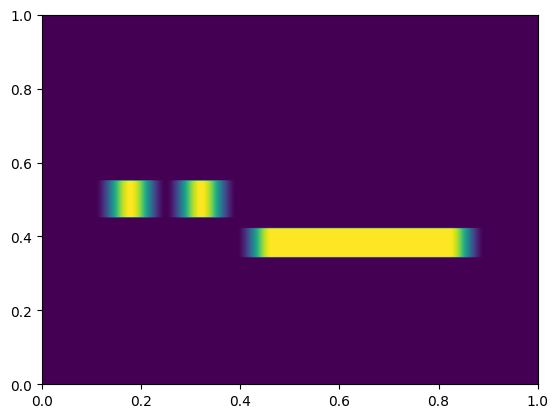

In [2]:
f0_hz = 0e9
grid_size = 106
carrier = nrCarrierConfig(NSizeGrid = 106, SubcarrierSpacing = 15)
pci = 69
ssb_grid = np.zeros((240,4), dtype='complex')
ssb_grid[nrPSSIndices(), 0] = nrPSS(pci)
ssb_grid[nrPSSIndices(), 2] = nrSSS(pci)
ressource_grid = nrResourceGrid(carrier)
ressource_grid[ressource_grid.shape[0] // 2 - ssb_grid.shape[0] // 2 : ressource_grid.shape[0] // 2 + ssb_grid.shape[0] // 2,
               2:6] = ssb_grid

# dummy data
num_data_re = 100
data_offset_re = 100
num_data_sym = 6
data_range = range(ressource_grid.shape[0] // 2 + data_offset_re, ressource_grid.shape[0] // 2 + data_offset_re + num_data_re)
ressource_grid[data_range, 6:6 + num_data_sym] = np.ones((num_data_re, num_data_sym), dtype='complex')

waveform, ofdm_info = nrOFDMModulate(carrier, ressource_grid, initialNSlot = 0, CarrierFrequency = f0_hz)
plt.imshow(np.abs(ressource_grid), extent=[0,1,0,1], aspect='auto')

In [3]:
decimation_factor = 1
# offset_rb = 0
fs = ofdm_info['SampleRate']
rx_waveform = waveform.copy()
# rx_waveform *= rx_waveform * np.exp(1j * 2 * np.pi * offset_rb * 12 * 15e3 / fs * np.arange(len(rx_waveform)))
# rx_waveform = scipy.signal.decimate(waveform, decimation_factor)
rx_fs = ofdm_info['SampleRate'] // decimation_factor
rx_grid_size = grid_size // decimation_factor

symbol 0, pos 160, CP 160, pos = 0
symbol 0, pos 160, CP 160, pos = 0
symbol 0, pos 160, CP 160, pos = 0
detected NID2 is 0 at 4544


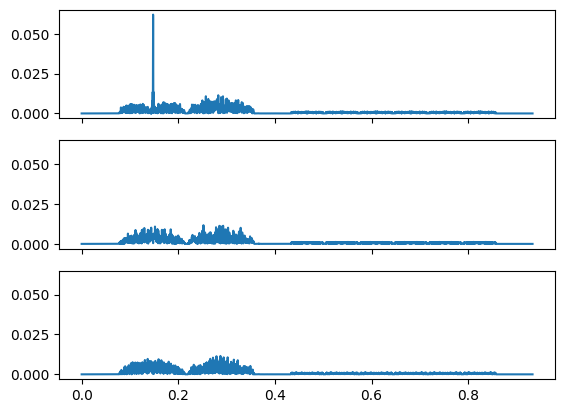

In [4]:
# detect PSS
rx_carrier = nrCarrierConfig(NSizeGrid = rx_grid_size, SubcarrierSpacing = 15)
Nfft = 1024
peak_value = np.zeros(3)
peak_index = np.zeros(3, 'int')
pssIndices = np.arange((rx_carrier.NSizeGrid * 12 // 2 - 64), (rx_carrier.NSizeGrid * 12 // 2 + 63))
fig, axs = plt.subplots(3, 1, facecolor='w', sharex=True, sharey=True)
for current_NID2 in np.arange(3, dtype='int'):
    slotGrid = nrResourceGrid(rx_carrier)
    slotGrid = slotGrid[:, 0]
    slotGrid[pssIndices] = nrPSS(current_NID2)
    [refWaveform, info] = nrOFDMModulate(rx_carrier, slotGrid)
    refWaveform = refWaveform[info['CyclicPrefixLengths'][0]:]; # remove CP

    temp = scipy.signal.correlate(rx_waveform[:int(25e-3 * fs)], refWaveform, 'valid')  # correlate over 25 ms
    peak_index[current_NID2] = np.argmax(np.abs(temp))
    peak_value[current_NID2] = np.abs(temp[peak_index[current_NID2]])
    t_corr = np.arange(temp.shape[0]) / rx_fs * 1e3
    axs[current_NID2].plot(t_corr, np.abs(temp))
detected_NID2 = np.argmax(peak_value)
print(f'detected NID2 is {detected_NID2} at {peak_index[detected_NID2]}')

In [6]:
nrbSSB = 20
refGrid = np.zeros((nrbSSB*12, 1), dtype='complex')
refGrid[nrPSSIndices(), 0] = nrPSS(detected_NID2)
timingOffset = nrTimingEstimate(waveform = rx_waveform, nrb = nrbSSB, scs = 15, initialNSlot = 2, refGrid = refGrid,
                                SampleRate = rx_fs, CarrierFrequency = f0_hz)
print(timingOffset)

IndexError: index 2 is out of bounds for axis 1 with size 1

symbol 2, pos 4544, CP 144, pos 0
symbol 3, pos 6736, CP 144, pos 2192
symbol 4, pos 8928, CP 144, pos 4384
symbol 5, pos 11120, CP 144, pos 6576
symbol 6, pos 13312, CP 144, pos 8768
symbol 7, pos 15520, CP 160, pos 10960
symbol 8, pos 17712, CP 144, pos 13168
symbol 9, pos 19904, CP 144, pos 15360
symbol 10, pos 22096, CP 144, pos 17552
symbol 11, pos 24288, CP 144, pos 19744
symbol 12, pos 26480, CP 144, pos 21936
symbol 13, pos 28672, CP 144, pos 24128


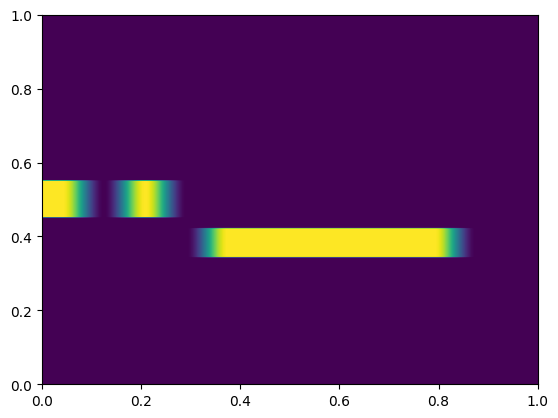

In [ ]:
# demodulate complete rx waveform
rxGrid = nrOFDMDemodulate(waveform = rx_waveform[timingOffset:], nrb = rx_grid_size, scs = 15, initialNSlot = 2,
                          SampleRate = rx_fs, CarrierFrequency = f0_hz)
rxGrid /= np.max((rxGrid.real.max(), rxGrid.imag.max()))
plt.imshow(np.abs(rxGrid), extent=[0,1,0,1], aspect='auto')

Text(0.5, 0.95, 'SSS symbols')

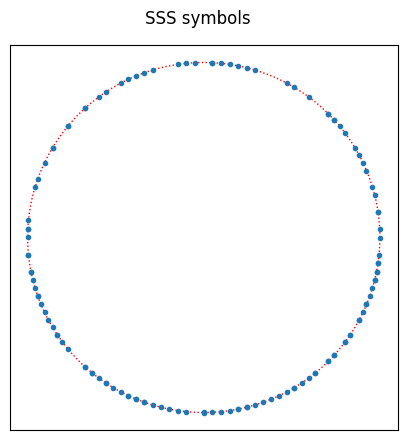

In [ ]:
sssIndices = nrPSSIndices() + rxGrid.shape[0] // 2 - 120
sssRx = nrExtractResources(sssIndices, rxGrid[:, 2:])
sssRx /= np.max((sssRx.real.max(), sssRx.imag.max())) # scale sssRx symbols individually

fig, axs = plt.subplots(1, 1, figsize=(5, 5), facecolor='w', sharex=True, sharey=True)
axs.plot(sssRx.real, sssRx.imag, '.')
axs.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
axs.set_xticks([])
axs.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('SSS symbols', y=0.95)

detected NID1 is 168
detected NID is 504


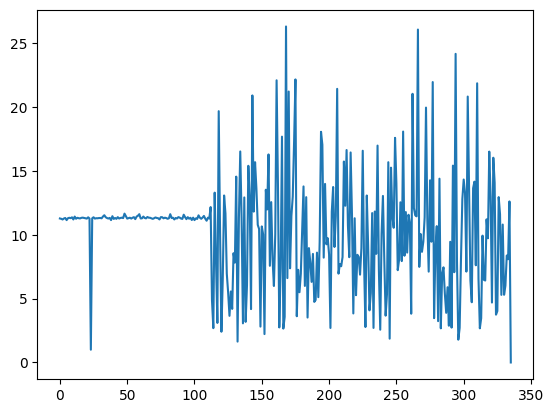

In [ ]:
sssEst = np.zeros(336)
for NID1 in range(335):
    ncellid = (3*NID1) + detected_NID2
    sssRef = nrSSS(ncellid)
    sssEst[NID1] = np.abs(np.vdot(sssRx, sssRef))

detected_NID1 = np.argmax(sssEst)
detected_NID = detected_NID1*3 + detected_NID2
print(f'detected NID1 is {detected_NID1}')
print(f'detected NID is {detected_NID}')
plt.plot(sssEst)
plt.show()

(-3.141592653589793, 3.141592653589793)

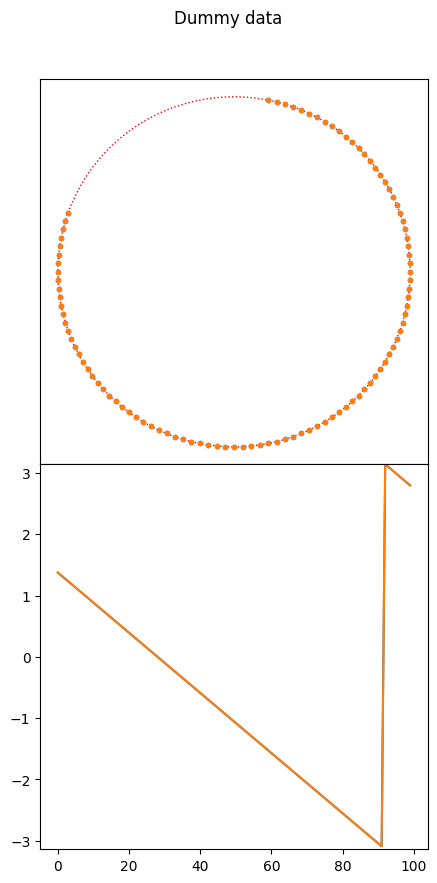

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(5, 10), facecolor='w', sharex=False, sharey=False)
data_range = range(rxGrid.shape[0] // 2 + data_offset_re, rxGrid.shape[0] // 2 + data_offset_re + num_data_re)
axs[0].plot(rxGrid[data_range, 7:9].real, rxGrid[data_range, 7:9].imag, '.')
axs[0].add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
axs[0].set_xticks([])
axs[0].set_yticks([])
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('Dummy data', y=0.95)
# phase
axs[1].plot(np.angle(rxGrid[data_range, 7:9]))
axs[1].set_ylim([-np.pi, np.pi])


In [ ]:
# demod data 